In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import sys, getopt
import csv
import pickle

pd.set_option('display.max_rows', 500)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
import seaborn as sns
sns.set_style("darkgrid")

import umap
from sklearn.decomposition import TruncatedSVD as tsvd

def nearZeroVarDropAuto(df,thresh=0.99):
    vVal=df.var(axis=0).values
    cs=pd.Series(vVal).sort_values(ascending=False).cumsum()
    remove=cs[cs>cs.values[-1]*thresh].index.values
    return df.drop(df.columns[remove],axis=1)

In [2]:
#%run SodaKick_download_functions.ipynb

In [3]:
#all_players=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_separate_teams_220218.h5',key='pl') 
all_players=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_220223.h5',key='pl') 

In [4]:
tmp=all_players.copy(deep=True)
tmp.drop(['player','squad','position','season','nationality','league'],axis=1,inplace=True)
tmp=(tmp-tmp.mean(axis=0))/tmp.std(axis=0)
tmp.fillna(0,inplace=True)

In [137]:
ts=tsvd(n_components=int(tmp.shape[1])-1, random_state=32)
ts.fit(tmp)
tsvd_var_ratios = ts.explained_variance_ratio_

def select_n_components(var_ratio, goal_var: float) -> int:

    total_variance = 0.0
    n_components = 0

    for explained_variance in var_ratio:
        total_variance += explained_variance        
        n_components += 1
        if total_variance >= goal_var:
            break

    return n_components
num_comp=select_n_components(tsvd_var_ratios, 0.8)
print(num_comp)
ts=tsvd(n_components=num_comp, random_state=32)
all_players_tsvd=ts.fit_transform(tmp)

15


In [126]:
with open(r'/Users/federico comitani/GitHub/sodakick/data/tsvd_220223.pkl', 'wb') as pk:
    pickle.dump(ts,pk)

In [127]:
#pd.DataFrame(all_players_tsvd).to_hdf('/Users/federico comitani/GitHub/sodakick/data/svd_separate_teams_220218.h5',key='svd') 
pd.DataFrame(all_players_tsvd).to_hdf('/Users/federico comitani/GitHub/sodakick/data/svd_220223.h5',key='svd') 

In [115]:
"""import umap

mapping=umap.UMAP(metric='jaccard', n_components=2, min_dist=.5, spread=2, n_neighbors=int(np.sqrt(tmp.shape[0])/2), \
                                n_epochs=1000, learning_rate=0.01, \
                                verbose=False, random_state=32)

mapping.fit(tmp.astype(float).values)
mh=pd.DataFrame(mapping.transform(tmp.values), index=tmp.index)
mh=(mh-mh.min())/(mh.max()-mh.min())
mh.to_hdf('/Users/federico comitani/GitHub/sodakick/data/prj_jaccard_separate_teams_220218.h5',key='pl') """

"import umap\n\nmapping=umap.UMAP(metric='jaccard', n_components=2, min_dist=.5, spread=2, n_neighbors=int(np.sqrt(tmp.shape[0])/2),                                 n_epochs=1000, learning_rate=0.01,                                 verbose=False, random_state=32)\n\nmapping.fit(tmp.astype(float).values)\nmh=pd.DataFrame(mapping.transform(tmp.values), index=tmp.index)\nmh=(mh-mh.min())/(mh.max()-mh.min())\nmh.to_hdf('/Users/federico comitani/GitHub/sodakick/data/prj_jaccard_separate_teams_220218.h5',key='pl') "

In [116]:
"""print([tmp.columns[x] for _, x in sorted(zip(ts.components_[0], np.arange(tmp.shape[1])))][::-1][:10])
print([tmp.columns[x] for _, x in sorted(zip(ts.components_[0], np.arange(tmp.shape[1])))][::-1][-10:])

#ball control"""

'print([tmp.columns[x] for _, x in sorted(zip(ts.components_[0], np.arange(tmp.shape[1])))][::-1][:10])\nprint([tmp.columns[x] for _, x in sorted(zip(ts.components_[0], np.arange(tmp.shape[1])))][::-1][-10:])\n\n#ball control'

In [153]:
mapping=umap.UMAP(metric='cosine', n_components=2, min_dist=.5, spread=.5, n_neighbors=int(np.sqrt(tmp.shape[0])/4), \
                                n_epochs=1000, learning_rate=0.01, \
                                verbose=False, random_state=8)

mapping.fit(tmp.astype(float).values)
mh2=pd.DataFrame(mapping.transform(tmp.values), index=tmp.index)
mh2=(mh2-mh2.min())/(mh2.max()-mh2.min())

Text(0, 0.5, 'UMAP 2')

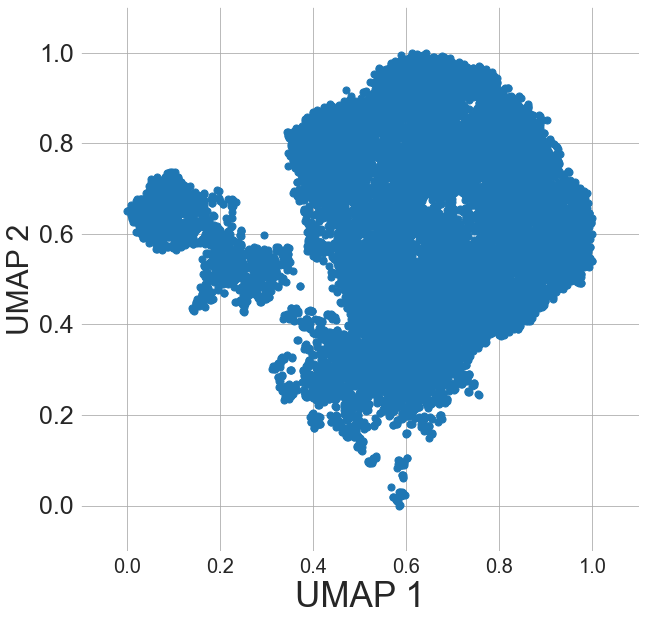

In [154]:
fig, ax = plt.subplots(1, 1,figsize=(10,10))
#plt.axis('off')
ax.set_facecolor('white')
plt.grid(color='#aaaaaa')


plt.scatter(mh2[0],mh2[1], s=50)

ax.tick_params(axis='y', which='major', labelsize=0)
ax.tick_params(axis='x', which='major', labelsize=0)

ax.set_xticks(np.linspace(0,1,6))
ax.set_xticklabels(['{:.1f}'.format(x) for x in np.linspace(0,1,6)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.xlim((-.1,1.1))
plt.xlabel('UMAP 1', fontsize=35)


ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels(['{:.1f}'.format(x) for x in np.linspace(0,1,6)])
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25) 
    
plt.ylim((-.1,1.1))
plt.ylabel('UMAP 2', fontsize=30)

In [155]:
#mh2.to_hdf('/Users/federico comitani/GitHub/sodakick/data/prj_minkowski_separate_teams_220218.h5',key='pl') 
mh2.to_hdf('/Users/federico comitani/GitHub/sodakick/data/prj_220223.h5',key='pl') 

In [5]:
mapping=umap.UMAP(metric='mahalanobis', n_components=2, min_dist=.5, spread=.5, n_neighbors=int(np.sqrt(tmp.shape[0])/4), \
                                n_epochs=1000, learning_rate=0.01, \
                                verbose=False, random_state=8)

mapping.fit(tmp.astype(float).values)
mh2=pd.DataFrame(mapping.transform(tmp.values), index=tmp.index)
mh2=(mh2-mh2.min())/(mh2.max()-mh2.min())

/Users/federico comitani/.local/lib/python3.7/site-packages/pynndescent/pynndescent_.py:924: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


Text(0, 0.5, 'UMAP 2')

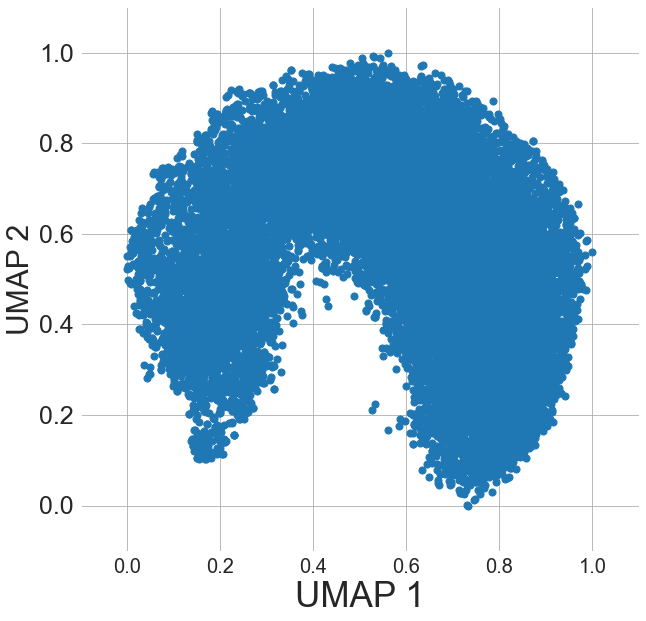

In [6]:
fig, ax = plt.subplots(1, 1,figsize=(10,10))
#plt.axis('off')
ax.set_facecolor('white')
plt.grid(color='#aaaaaa')


plt.scatter(mh2[0],mh2[1], s=50)

ax.tick_params(axis='y', which='major', labelsize=0)
ax.tick_params(axis='x', which='major', labelsize=0)

ax.set_xticks(np.linspace(0,1,6))
ax.set_xticklabels(['{:.1f}'.format(x) for x in np.linspace(0,1,6)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.xlim((-.1,1.1))
plt.xlabel('UMAP 1', fontsize=35)


ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels(['{:.1f}'.format(x) for x in np.linspace(0,1,6)])
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25) 
    
plt.ylim((-.1,1.1))
plt.ylabel('UMAP 2', fontsize=30)

In [ ]:
#raccoon??

In [40]:
with open(r'/Users/federico comitani/GitHub/sodakick/data/allplayers_weighted.pkl', 'rb') as pk:
    allpl_weighted=pickle.load(pk)
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/allplayers_weighted_tsvd.pkl', 'rb') as pk:
    allpl_weighted_ts=pickle.load(pk)

In [88]:
list(allpl_weighted[-1])

KeyError: 'team'

In [75]:
import umap
sel=allpl_weighted[-1]
sel_cut=sel
#sel_cut=sel[[x for x in allpl_weighted[3].columns if x not in ['minutes','birth_year']]][sel['keeper']==0]
mapping=umap.UMAP(metric='jaccard', n_components=2, min_dist=.5, spread=2, n_neighbors=int(np.sqrt(sel_cut.shape[0])/2), \
                                n_epochs=1000, learning_rate=0.01, \
                                verbose=False, random_state=32)

mapping.fit(sel_cut.astype(float).values)
mh=pd.DataFrame(mapping.transform(sel_cut.values), index=sel_cut.index)
mh=(mh-mh.min())/(mh.max()-mh.min())

//miniconda3/lib/python3.7/site-packages/umap/umap_.py:1530: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


In [49]:
from scipy.stats import spearmanr

sp=[[],[]]
for c in sel_cut.columns:
    sp[0].append(spearmanr(sel_cut[c],mh[0])[0])
    sp[1].append(spearmanr(sel_cut[c],mh[1])[0])
    
sp=pd.DataFrame(sp,columns=sel_cut.columns).T
sp.sort_values(1,ascending=False)

,0,1
errors,-0.575214,0.127734
blocked_shots_saves,-0.375373,0.117646
xa_net,-0.008282,0.106943
own_goals,-0.299406,0.104676
xg_net,0.025232,0.099634
birth_year,0.316499,0.097222
pens_conceded,-0.477253,0.096873
cards_yellow_red,-0.278954,0.076457
cards_red,-0.378139,0.068177
passes_total_distance,-0.955815,0.056827


Text(0, 0.5, 'UMAP 2')

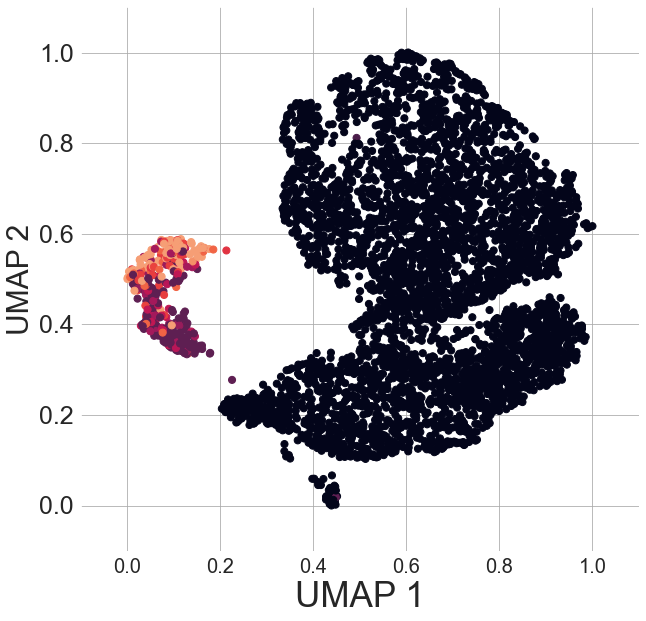

In [84]:
fig, ax = plt.subplots(1, 1,figsize=(10,10))
#plt.axis('off')
ax.set_facecolor('white')
plt.grid(color='#aaaaaa')


plt.scatter(mh[0],mh[1], s=50, c=sel_cut['keeper'])

ax.tick_params(axis='y', which='major', labelsize=0)
ax.tick_params(axis='x', which='major', labelsize=0)


ax.set_xticks(np.linspace(0,1,6))
ax.set_xticklabels(['{:.1f}'.format(x) for x in np.linspace(0,1,6)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.xlim((-.1,1.1))
plt.xlabel('UMAP 1', fontsize=35)



ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels(['{:.1f}'.format(x) for x in np.linspace(0,1,6)])
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25) 
    
plt.ylim((-.1,1.1))
plt.ylabel('UMAP 2', fontsize=30)

In [21]:
allpl_weighted[3]['x_coor']=mh[0]
allpl_weighted[3]['y_coor']=mh[1]

In [83]:
allpl_weighted[3]['keeper'].value_counts()

0.000000    4244
1.000000     154
3.266667      80
1.933333      27
2.733333      23
2.428571      18
1.666667      18
2.333333      11
1.571429       7
1.533333       7
1.857143       6
2.466667       5
4.066667       2
0.800000       1
3.000000       1
3.133333       1
Name: keeper, dtype: int64

In [78]:
mh.to_hdf('/Users/federico comitani/GitHub/sodakick/data/allpl_proj.h5',key='df')

In [22]:
allpl_weighted[3].to_csv('/Users/federico comitani/GitHub/sodakick/data/all_pl_test1.csv')

# now build them

In [ ]:
import warnings
warnings.filterwarnings('ignore')

inputs=[]
outputs=[]
lineups=[]

exit=False
for i,series in enumerate(['SA2021','SA1920','BL2021','BL1920','LU2021','LU1920','PL2021','PL1920','LL2021','LL1920']):
    
    print(series)
    
    for match in df_fixs[i]['match_report'].values:

        try:

            inp, results, lineup = clean_report(match, players_year_dict[series[2:]])
            
            if inp.shape[0]<48:
                print(match)
                exit=True
                break
            
            inputs.append(inp.astype(float).values.flatten())
            outputs.append(results.astype(float).values.flatten())
            lineups.append(lineup.reset_index())
            
        except:

            pass
        
    if exit:
        break
        
    print(len(inputs))
    
inputs=np.array(inputs)
outputs=np.array(outputs)


with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_inp_a_210614.pkl', 'wb') as pk:
    pickle.dump(inputs,pk)

with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_out_a_210614.pkl', 'wb') as pk:
    pickle.dump(outputs,pk)
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_lineup_a_210614.pkl', 'wb') as pk:
    pickle.dump(lineups,pk)

SA2021
357
SA1920
737
BL2021
1024
BL1920
1330
LU2021
1689
LU1920
1968
PL2021
2315
PL1920


In [18]:
import warnings
warnings.filterwarnings('ignore')

inputs=[]
outputs=[]
lineups=[]

exit=False
for i,series in enumerate(['SA1819','SA1718','BL1819','BL1718','LU1819','LU1718','PL1819','PL1718','LL1819','LL1718']):
    
    print(series)
    
    for match in df_fixs[i]['match_report'].values:

        try:

            inp, results, lineup = clean_report(match, players_year_dict[series[2:]])
            
            if inp.shape[0]<48:
                print(match)
                exit=True
                break

            inputs.append(inp.astype(float).values.flatten())
            outputs.append(results.astype(float).values.flatten())
            lineups.append(lineup.reset_index())
            
        except:

            pass

    print(len(inputs))
    
inputs=np.array(inputs)
outputs=np.array(outputs)


with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_inp_b_210614.pkl', 'wb') as pk:
    pickle.dump(inputs,pk)

with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_out_b_210614.pkl', 'wb') as pk:
    pickle.dump(outputs,pk)
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_lineup_b_210614.pkl', 'wb') as pk:
    pickle.dump(lineups,pk)

SA1819
357
SA1718
737
BL1819
1024
BL1718
1330
LU1819
1688
LU1718
1967
PL1819
2314
PL1718
2692
LL1819
3044
LL1718
3421


# trying and merging them

In [20]:
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_inp_a.pkl', 'rb') as pk:
    inputs=pickle.load(pk)

with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_out_a.pkl', 'rb') as pk:
    outputs=pickle.load(pk)
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_inp_b.pkl', 'rb') as pk:
    inputs2=pickle.load(pk)

with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_out_b.pkl', 'rb') as pk:
    outputs2=pickle.load(pk)

In [21]:
inputs=np.concatenate([inputs,inputs2])
outputs=np.concatenate([outputs,outputs2])

In [22]:
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_inp.pkl', 'wb') as pk:
    pickle.dump(inputs,pk)

with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_weight_out.pkl', 'wb') as pk:
    pickle.dump(outputs,pk)